<a href="https://colab.research.google.com/github/lovekittynine/Annotated-DDPM/blob/master/stable_diffusion_play.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# stable diffusion model 试玩

In [1]:
!pip3 install -Uq transformers diffusers accelerate datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.4 MB/s eta 0:00:00


In [2]:
# stable diffusion pipeline
from diffusers import StableDiffusionPipelineSafe
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import requests
from io import BytesIO
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sd_pipeline = StableDiffusionPipelineSafe.from_pretrained("stabilityai/stable-diffusion-2-1-base").to(device)


# 节省显存
# torch_dtype=torch.float16[效果不太好]
# sd_pipeline.enable_attention_slicing()

generator = torch.Generator(device).manual_seed(94)

prompt = "palette knife painting of an autumn cityscape"
negative_prompt = "oversaturated, blurry, low quality"

pipe_output = sd_pipeline(prompt=prompt, negative_prompt=negative_prompt, height=480, width=640, guidance_scale=8, num_inference_steps=50, generator=generator)
pipe_output.images[0]


/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion_safe/pipeline_stable_diffusion_safe.py:584: UserWarning: Safety checker disabled!
  warnings.warn("Safety checker disabled!")


  0%|          | 0/35 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion_safe/pipeline_stable_diffusion_safe.py:327: FutureWarning: The decode_latents method is deprecated and will be removed in a future version. Please use VaeImageProcessor instead
  warnings.warn(


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

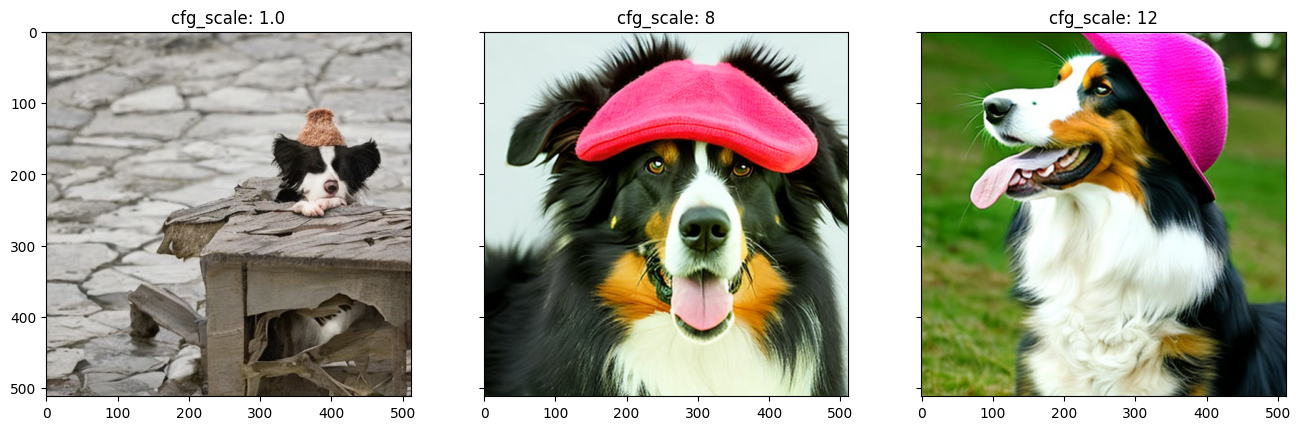

In [ ]:
# 探索CFG-scale尺度的影响
cfg_scale = [1.0, 8, 12]
prompt = "A collie with a pink hat"
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)

for i, cfg in enumerate(cfg_scale):
    im = sd_pipeline(prompt=prompt, guidance_scale=cfg, num_inference_steps=35, generator=generator).images[0]
    axes[i].imshow(im)
    axes[i].set_title(f"cfg_scale: {cfg}")

plt.show()



In [ ]:
sd_pipeline.scheduler.init_noise_sigma
torch.cuda.empty_cache()

In [4]:
# 探索img2img pipeline
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = Image.open(BytesIO(requests.get(img_url).content)).convert("RGB")
mask_image = Image.open(BytesIO(requests.get(mask_url).content)).convert("RGB")

print(init_image.size)

(512, 512)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

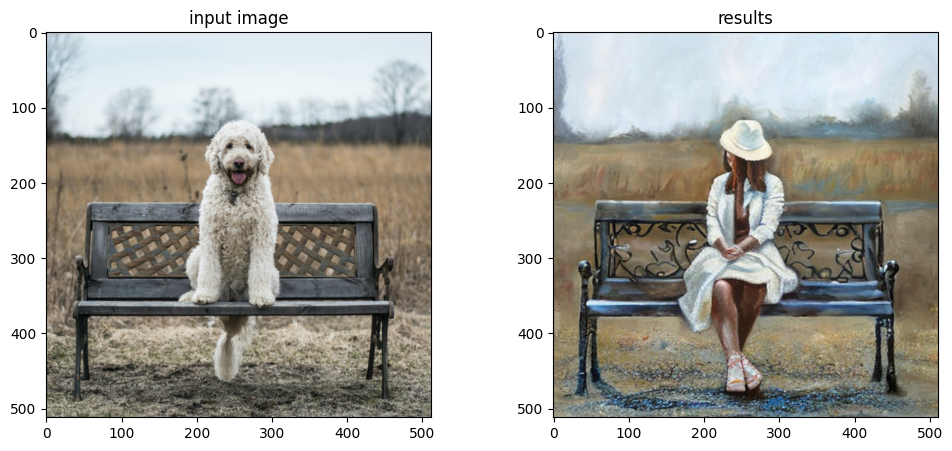

In [5]:
from diffusers import StableDiffusionImg2ImgPipeline
img2img_pipeline = StableDiffusionImg2ImgPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base").to(device)

prompt = "an oil painting of a beautiful women on a bench"
generator = torch.Generator(device).manual_seed(0)

# note output image is pil default
# 这里resize图像会导致vae输出分布发生变化, 生成的图像不理想
# init_image = init_image.resize((128, 128))

output = img2img_pipeline(prompt=prompt, image=init_image, strength=0.6, generator=generator, num_inference_steps=50).images[0]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(init_image)
axs[0].set_title("input image")

axs[1].imshow(output)
axs[1].set_title("results")

plt.show()

torch.cuda.empty_cache()

In [ ]:
generator.device

device(type='cuda')

0
tensor([981, 961, 961, 941, 921, 901, 881, 861, 841, 821, 801, 781, 761, 741,
        721, 701, 681, 661, 641, 621, 601, 581, 561, 541, 521, 501, 481, 461,
        441, 421, 401, 381, 361, 341, 321, 301, 281, 261, 241, 221, 201, 181,
        161, 141, 121, 101,  81,  61,  41,  21,   1])
torch.Size([2, 77, 1024])


  0%|          | 0/51 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_img2img.py:435: FutureWarning: The decode_latents method is deprecated and will be removed in a future version. Please use VaeImageProcessor instead
  warnings.warn(


(1, 512, 512, 3) float32


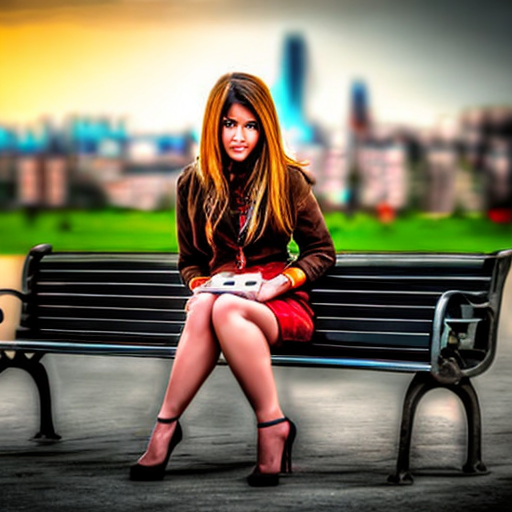

In [16]:
# 手动测试img2img效果, 在stable diffusion基础上实现img2img pipeline
from tqdm.auto import tqdm
strength = 1.0
num_inference_steps = 50

prompt = "a beautiful girl, bench, HDR, cityscape, atmosphere, best quality, studio lighting, sharp focus, professional, vivid colors"
negative_prompt = "blurry, mutated hands and fingers, deformed, poorly drawn face, extra limb, poorly drawn hands, floating limbs, disconnected limbs"

with torch.inference_mode():

    image = torch.from_numpy(np.array(init_image, dtype=np.float32) / 255.0).permute([2,0,1]).unsqueeze(0).to(device)
    image = 2.0*image - 1.0

    # 从输入图片latent space空间采样
    init_latents = img2img_pipeline.vae.encode(image).latent_dist.sample(generator)
    init_latents *= img2img_pipeline.vae.config.scaling_factor

    # 设置推理时时间步
    init_timestep = min(int(num_inference_steps*strength), num_inference_steps)
    # 推理起始时刻
    start_t = max(num_inference_steps-init_timestep, 0)
    print(start_t)
    # 推理时间步
    img2img_pipeline.scheduler.set_timesteps(num_inference_steps=50)
    # 实际推理时间步一共只有30 = num_inference_steps * strength步
    timesteps = img2img_pipeline.scheduler.timesteps[start_t:]
    print(timesteps)

    text_embeddings = img2img_pipeline._encode_prompt(prompt, device, 1, True, "")
    # 不设置无分类器引导时, text embedding shape: 1x77x1024
    # 设置无分类器引导时, text embedding shape: 2x77x1024
    print(text_embeddings.shape)

    noise = torch.randn((1, 4, 64, 64), generator=generator, device=device)
    # 加噪输入
    model_inputs = img2img_pipeline.scheduler.add_noise(init_latents, noise, timesteps[0])

    # # 单纯从噪声输入[文生图]
    # model_inputs = noise

    for t in tqdm(timesteps):
        latent_model_inputs = torch.cat([model_inputs] * 2)
        # print(model_inputs.shape)
        latent_model_inputs = img2img_pipeline.scheduler.scale_model_input(latent_model_inputs)
        # predict noise
        noise_pred = img2img_pipeline.unet(latent_model_inputs, t, encoder_hidden_states=text_embeddings).sample
        # 分别得到无条件噪声预测, 文本条件噪声预测
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        # 预测噪声朝着文本条件方向移动
        noise_pred = noise_pred_uncond + 7.5*(noise_pred_text - noise_pred_uncond)

        # 得到前一步去噪结果
        model_inputs = img2img_pipeline.scheduler.step(noise_pred, t, model_inputs).prev_sample

    # 解码得到预测图片
    img = img2img_pipeline.decode_latents(model_inputs)
    print(img.shape, img.dtype)

img2img_pipeline.numpy_to_pil(img)[0]




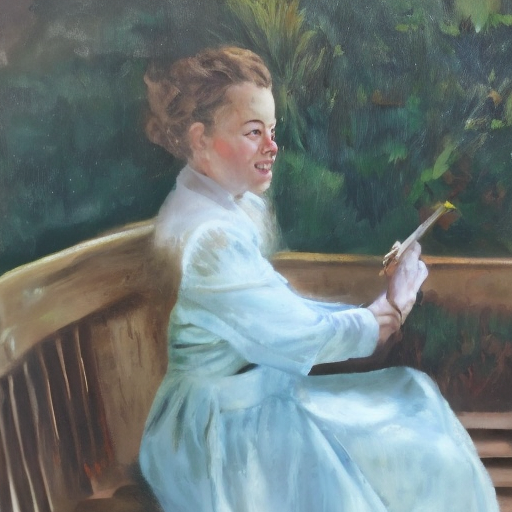

In [ ]:
img2img_pipeline.numpy_to_pil(img)[1]

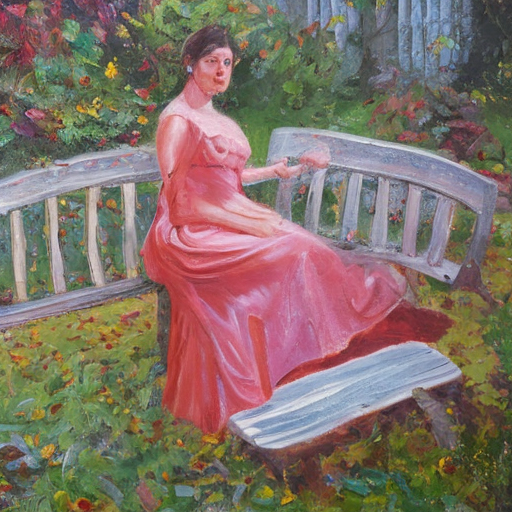

In [ ]:
img2img_pipeline.numpy_to_pil(img)[2]

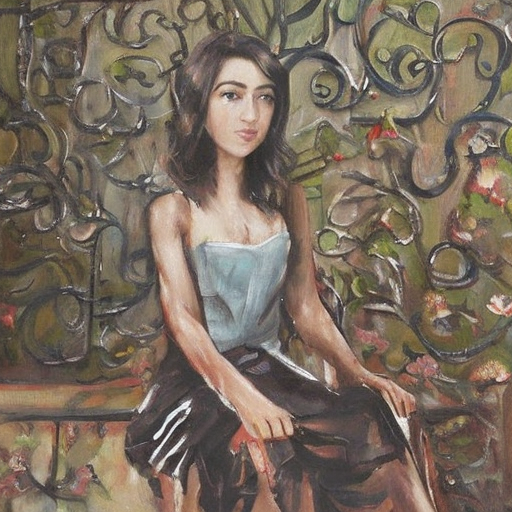

In [ ]:
img2img_pipeline.numpy_to_pil(img)[3]

In [13]:
print(img2img_pipeline.scheduler.order)
print(img2img_pipeline.scheduler.timesteps)
print(len(img2img_pipeline.scheduler.timesteps))

1
tensor([981, 961, 961, 941, 921, 901, 881, 861, 841, 821, 801, 781, 761, 741,
        721, 701, 681, 661, 641, 621, 601, 581, 561, 541, 521, 501, 481, 461,
        441, 421, 401, 381, 361, 341, 321, 301, 281, 261, 241, 221, 201, 181,
        161, 141, 121, 101,  81,  61,  41,  21,   1])
51
